In [ ]:
!unzip /content/drive/MyDrive/images.zip

In [2]:
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras version
import keras
print('keras: %s' % keras.__version__)

tensorflow: 2.4.0
keras: 2.4.3


**Import Necessary File**

In [4]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam,SGD,RMSprop

**Read Excel File and convert into Data Frame**

In [5]:
import numpy as np
import pandas as pd
import re
df = pd.DataFrame(pd.read_excel('/content/drive/MyDrive/dataset 1.xlsx')).fillna(' ') 
df.head()

,Title,Description,Material,Pattern,Neckline,Image_Path
0,Peach Poly Crepe jumpsuit,This stylish foil print kurta from janasya is ...,Crepe,Printed,Round Neck,/images/pic_0.jpg
1,Light Brown Bias Yoke Checks Top,This check pattern top by Work Label is crafte...,Cotton,Checks,Round Neck,/images/pic_1.jpg
2,Off White Geometric Straight Cotton Dobby Top ...,"Featuring elegant printed details, this off wh...",Viscose,Checks,Round Neck,/images/pic_2.jpg
3,Blue Me Away Cape Top,Add an extra dose of style to your casual ward...,Polyester,Solid/Plain,V-Neck,/images/pic_3.jpg
4,Yellow On A High Gown,Yellow polyester georgette maxi dress. Polyest...,Polyester,Solid/Plain,V-Neck,/images/pic_4.jpg


**Preparing Text Input**

In [6]:

df['Description'] = df['Description'].apply(lambda x: re.sub(r'http\S+', '', str(x)))
df['Description'] = df['Description'].apply(lambda x: re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", '', x))
df['Description'] = df['Description'].str.lower()
df['Description'] = df['Description'].apply(lambda x: x.split())
print(df.head())

                                               Title  ...         Image_Path
0                          Peach Poly Crepe jumpsuit  ...  /images/pic_0.jpg
1                   Light Brown Bias Yoke Checks Top  ...  /images/pic_1.jpg
2  Off White Geometric Straight Cotton Dobby Top ...  ...  /images/pic_2.jpg
3                              Blue Me Away Cape Top  ...  /images/pic_3.jpg
4                              Yellow On A High Gown  ...  /images/pic_4.jpg

[5 rows x 6 columns]


In [8]:
x_text = df['Description'].copy()
text_list = []
dict = {}
for i in range(0,len(x_text)):
    text = [word for word in x_text[i] if len(word)>1]
    for words in text:
        if words in dict:    
        # If the word exists in dictionary then simply increase its count           
            dict[words] += 1             
        else:  
        # If the word does not exists in dictionary update the dictionary and make its count 1   
            dict.update({words: 1})
    text.append('endseq')
    text.insert(0,'startseq')
    text = ' '.join(text)    
    text_list.append(text)

voc_size =0 
for word in dict:  
    if dict[word] >= 1: 
        voc_size= voc_size+1

In [9]:
print(voc_size)
print(text_list[1])

1614
startseq this check pattern top by work label is crafted in cotton featuring bias check at the yoke and straight check pattern in bottom half smart round neckline 34th sleeves this mid hip length top offers stylish comfortable fit style this top with trouserskirt and medium high heels for chic look at work this top can also be styled with pair of stud earrings and pair your regular sneakers to attain casual look endseq


**Spliting Description for Train and Validation according to image**

In [10]:

train_text = text_list[:401]
val_text = text_list[401:] 

In [11]:
t1 = Tokenizer(num_words=voc_size)
t1.fit_on_texts(train_text)
wordToSequenceTrain=t1.texts_to_sequences(train_text)
maxSentenceLength = max([len(i) for i in wordToSequenceTrain])
print(maxSentenceLength)
print(wordToSequenceTrain[2])

wordToSequenceVal=t1.texts_to_sequences(val_text)
print(wordToSequenceVal[2])
maxSentenceLength2 = max([len(i) for i in wordToSequenceVal])
print(maxSentenceLength2)

83
[4, 76, 110, 42, 93, 3, 184, 68, 11, 1, 137, 152, 17, 251, 289, 173, 38, 115, 8, 25, 47, 73, 9, 3, 152, 2, 18, 16, 37, 20, 1, 38, 52, 8, 22, 6, 14, 5]
[4, 403, 13, 388, 558, 1, 26, 74, 89, 3, 78, 10, 28, 40, 100, 156, 69, 313, 15, 40, 100, 144, 1, 63, 43, 23, 6, 125, 7, 102, 9, 2, 245, 324, 287, 161, 1, 38, 97, 54, 284, 3, 14, 8, 6, 374, 934, 5]
72


**Extract Image feature for all images using VGG16 and save to .pkl file**

In [12]:
def extract_features(directory):	
	model = VGG16()	
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)	
	print(model.summary())
	features = {}
	for name in listdir(directory):
		filename = directory +"/" + name
		image = load_img(filename, target_size=(224, 224))		
		image = img_to_array(image)	
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))	
		image = preprocess_input(image)		
		feature = model.predict(image, verbose=0)
		image_id = name.split('.')[0]
		features[image_id] = feature
	return features
 

directory = '/content/images'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
dump(features, open('features.pkl', 'wb'))

553467904/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

**Load Image Feature in List**

In [14]:
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = [ all_features[k] for k in dataset]
	return features

**Spliting Image folder for Train and Validation**

In [16]:
train = []
val = []
x_image= df['Image_Path'].copy()
for i in range(0,len(x_image)):
    image = x_image[i].split('/')[2]
    img = image.split('.')[0]
    if i <=400:
        train.append(img)
    else:
        val.append(img)


print(train[1])
print(val[1])

pic_1
pic_402


**Prepare Training Dataset**

In [17]:
X1 = []
X2 = []
Y = []
train_image=load_photo_features('features.pkl', train)
for i in range(0,len(train_image)):
    for j in range(1,len(wordToSequenceTrain[i])):
        in_seq, out_seq = wordToSequenceTrain[i][:j], wordToSequenceTrain[i][j]
        in_seq = pad_sequences([in_seq], maxlen=maxSentenceLength)[0]
        out_seq = to_categorical([out_seq], num_classes=voc_size)[0]
        X1.append(train_image[i][0])
        X2.append(in_seq)
        Y.append(out_seq)

**Prepare Validation Dataset**

In [18]:
x1 = []
x2 = []
y = []
val_image=load_photo_features('features.pkl', val)
for i in range(0,len(val_image)):
    for j in range(1,len(wordToSequenceVal[i])):
        in_seq2, out_seq2 = wordToSequenceVal[i][:j], wordToSequenceVal[i][j]
        in_seq2 = pad_sequences([in_seq2], maxlen=maxSentenceLength)[0]
        out_seq2 = to_categorical([out_seq2], num_classes=voc_size)[0]
        x1.append(val_image[i][0])
        x2.append(in_seq2)
        y.append(out_seq2)



In [19]:
train_input_1 = array(X1)
train_input_2 = array(X2)
train_output = array(Y)

val_input_1 = array(x1)
val_input_2 = array(x2)
val_output = array(y)

In [20]:
print(train_input_1.shape)
print(train_input_2.shape)
print(train_output.shape)

print(val_input_1.shape)
print(val_input_2.shape)
print(val_output.shape)


(13965, 4096)
(13965, 83)
(13965, 1614)
(3347, 4096)
(3347, 83)
(3347, 1614)


**Model**

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 83, 256)      413184      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_2[0][0]                    
____________________________________________________________________________________________

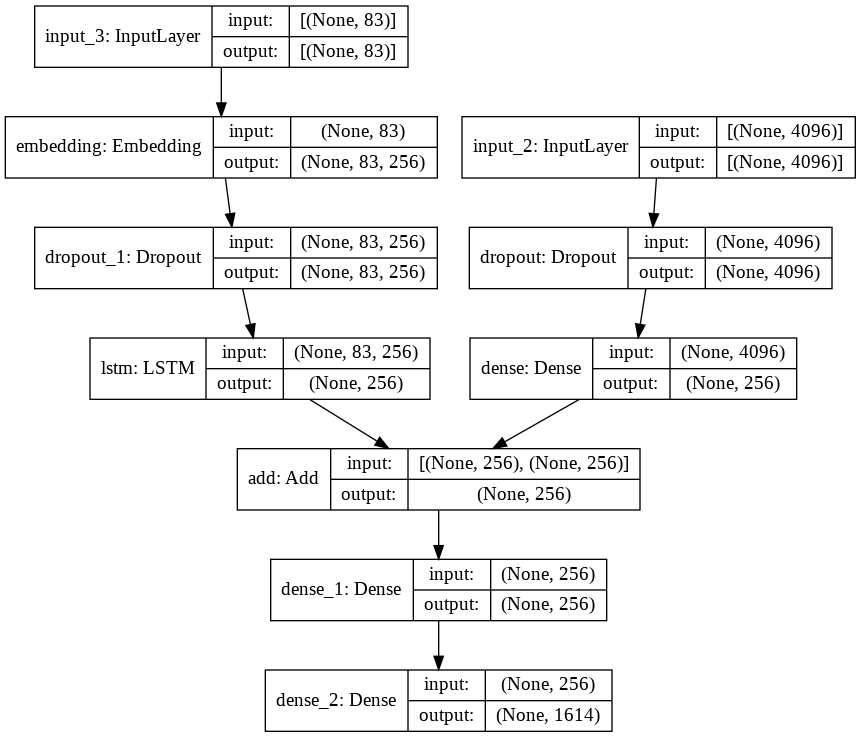

In [21]:
input1 = Input(shape=(4096,))
drop1 = Dropout(0.5)(input1)
dense1 = Dense(256, activation='relu')(drop1)
# sequence model
input2 = Input(shape=(maxSentenceLength,))
emb = Embedding(voc_size, 256, mask_zero=True)(input2)
drop2 = Dropout(0.5)(emb)
lstm = LSTM(256)(drop2)
# decoder model
decoder1 = add([dense1, lstm])
decoder2 = Dense(256, activation='relu')(decoder1)
output = Dense(voc_size, activation='softmax')(decoder2)
# tie it together [image, seq] [word]
model = Model(inputs=[input1, input2], outputs=output)
#opt = SGD(lr=0.001,momentum=0.99,clipvalue=0.9,clipnorm=1.)
#opt = Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
# summarize model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

In [22]:
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')

In [23]:
history=model.fit([train_input_1, train_input_2], train_output, epochs=35, verbose=2, callbacks=[checkpoint], validation_data=([val_input_1, val_input_2], val_output))


Epoch 1/35
437/437 - 85s - loss: 5.7581 - accuracy: 0.0554 - val_loss: 5.0377 - val_accuracy: 0.0896

Epoch 00001: val_loss improved from inf to 5.03774, saving model to model-ep001-loss5.758-val_loss5.038.h5
Epoch 2/35
437/437 - 81s - loss: 4.9455 - accuracy: 0.0976 - val_loss: 4.5061 - val_accuracy: 0.1622

Epoch 00002: val_loss improved from 5.03774 to 4.50611, saving model to model-ep002-loss4.945-val_loss4.506.h5
Epoch 3/35
437/437 - 81s - loss: 4.2670 - accuracy: 0.1948 - val_loss: 4.0129 - val_accuracy: 0.2910

Epoch 00003: val_loss improved from 4.50611 to 4.01289, saving model to model-ep003-loss4.267-val_loss4.013.h5
Epoch 4/35
437/437 - 81s - loss: 3.6752 - accuracy: 0.2784 - val_loss: 3.7210 - val_accuracy: 0.3508

Epoch 00004: val_loss improved from 4.01289 to 3.72102, saving model to model-ep004-loss3.675-val_loss3.721.h5
Epoch 5/35
437/437 - 81s - loss: 3.1723 - accuracy: 0.3464 - val_loss: 3.6243 - val_accuracy: 0.3753

Epoch 00005: val_loss improved from 3.72102 to 3.6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'upper_left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


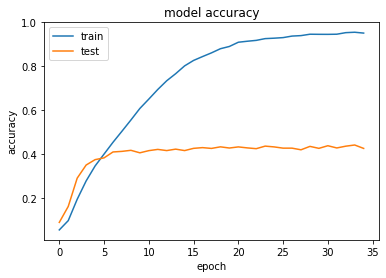

In [25]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper_left')
plt.show()

**Generate Description for entirely new photographs**

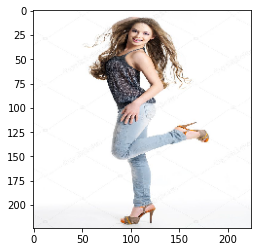

startseq this black dress by mish is crafted in polyester and features square neck and neckline pockets pockets and regular fit style this dress with pair of high heels and fine accessories to complete the look endseq


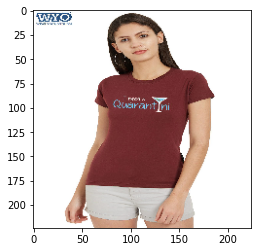

startseq this white tshirt by gap is crafted in cotton and features round neck and short sleeves and regular fit style this top with pair of jeans and sneakers to complete the look endseq


In [38]:
from numpy import argmax
from pickle import load
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
    
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature
 
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text
 
# load the tokenizer
#tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 83
# load the model
model = load_model('/content/model-ep006-loss2.730-val_loss3.620.h5')
# load and prepare the photograph
image1 = load_img('/content/t4.jpg', target_size=(224, 224))
plt.imshow(image1)
plt.show()
photo = extract_features('/content/t4.jpg')
# generate description
description = generate_desc(model, t1, photo, max_length)
print(description)
image2 = load_img('/content/test.jpg', target_size=(224, 224))
plt.imshow(image2)
plt.show()
photo = extract_features('/content/test.jpg')
# generate description
description = generate_desc(model, t1, photo, max_length)
print(description)